# Amazon Fine Food Reviews - Building a Co-review graph

In this lab, our general goal is to conduct some exploratory analysis of a medium - large dataset, namely, Amazon Fine Food Reviews, available from a [Kaggle Competition](https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews).

Our general goals are the following:

- Retrieve the dataset and upload it onto Colab;
- Build the associated Co-review graph.

## Retrieving the dataset
To retrieve this dataset, we need to be registered Kaggle users. Assuming this is the case, we basically have two options:

1. Download the dataset locally. This can be useful if you want to keep a copy of the data to work with directly on your machine. In this case, you will have to upload the data on Colab in order to work with it. There are several ways to do this, described [here](https://colab.research.google.com/notebooks/io.ipynb). Note that our compressed dataset is about 300MB's and proceeding this way may take some time, depending on your connection.
2. Transferring the data directly from Kaggle to Google. In my experience, this was extremely fast and it is the method I am going to use.

A nice review of all available methods, including the one I am using, can be found [here](https://towardsdatascience.com/7-ways-to-load-external-data-into-google-colab-7ba73e7d5fc7).

### Transferring dataset from Google to Colab
Go to your profile on Kaggle, then ```Account --> Create New API Token``` (you do not have to do every time you run your notebook). The result will be a file called ```kaggle.json```, which you save on your machine. Next, we upload this file to Google Colab as follows:

In [12]:
from google.colab import files

uploaded = files.upload()

Saving kaggle.json to kaggle (1).json


We next specify the above directory as the one to upload the Kaggle dataset to:

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

Next, we need to upload the dataset, issuing the necessary shell command. To do this, we can let Kaggle generate the right command for us. This is done from the Kaggle competion's Web page, in the top-right menu, clicking on the dots and then selecting ```Copy API Command``` as shown in the picture below:

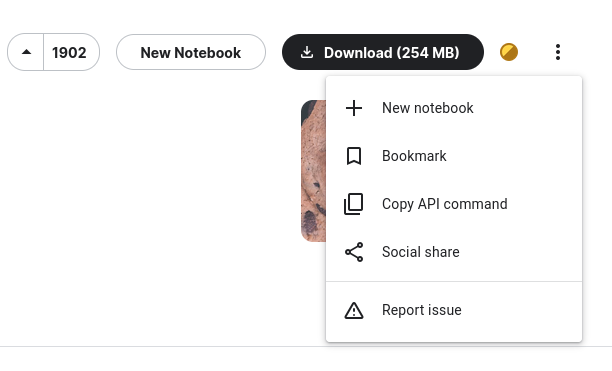

The copy-pasted command is the one shown below:

In [ ]:
!chmod 600 /content/kaggle.json

In [ ]:
!kaggle datasets download -d snap/amazon-fine-food-reviews

 90% 218M/242M [00:00<00:00, 317MB/s]
100% 242M/242M [00:00<00:00, 307MB/s]


We next check that everything is there:

In [ ]:
!ls

amazon-fine-food-reviews.zip  kaggle.json  sample_data


We now extract the files from the zipper archive. To this purpose, we use Python zipfile utility package:

In [ ]:
from zipfile import ZipFile

In [ ]:
# Create a ZipFile Object and load sample.zip in it
with ZipFile('amazon-fine-food-reviews.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

Let's check what files are there (we are looking for ```Reviews.csv```)

In [ ]:
!ls

amazon-fine-food-reviews.zip  database.sqlite  hashes.txt  kaggle.json	Reviews.csv  sample_data


There it is. Let us just perform a check that the file looks like it is supposed to be, by having a glance at the first 10 lines:

In [ ]:
!head -10 Reviews.csv

Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally co

Keeping roughly $10\%$ of the users for testing purposes. We will see why doing this is reasonable further in the course. For now, try to understand how ```sample_users``` works and why it does the job.

In [2]:
import pandas as pd

In [3]:
raw_pd = pd.read_csv("Reviews.csv")
print(f"The dataset has {raw_pd.__len__()} rows")
raw_pd.head()

The dataset has 568454 rows


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
# Given a Pandas frame raw_pd, save lines corresponding to approximately 10% of the users to file fout
# Note that all lines corresponding to sampled users are saved to fout
import csv
def sample_users(raw_pd, rate, buckets, fout):
    # using csv.writer to write every row
    writer = csv.DictWriter(fout, fieldnames=raw_pd.columns.to_list())
    writer.writeheader()
    for index, row in raw_pd.iterrows():
        if (hash(row["UserId"])%buckets < rate):
            # Save this line to fout
            # You have to complete this part of the function's body
            writer.writerow(row.to_dict())


sampled_file = "Reviews_sampled.csv"
rate = 10 # 10% of users
buckets = 100

fout = open(sampled_file, "w", encoding='utf8', newline='')
sample_users(raw_pd, rate, buckets, fout)
fout.close()

In [5]:
raw_pd_sampled = pd.read_csv("Reviews_sampled.csv")
print(f"The sampled dataset has {raw_pd_sampled.__len__()} rows")
raw_pd_sampled.head()

The sampled dataset has 56715 rows


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
1,17,B001GVISJM,A3KLWF6WQ5BNYO,Erica Neathery,0,0,2,1348099200,poor taste,I love eating them and they are good for watch...
2,60,B004N5KULM,A2QOGOXPOVKAJG,mimimc,0,0,5,1320105600,great deal.,"Halloween is over but, I sent a bag to my daug..."
3,61,B004N5KULM,A1ZR8O62VSU4OK,"Lisa J. Szlosek ""lisa""",2,4,3,1318723200,Better price for this at Target,Watch your prices with this. While the assort...
4,70,B000E7VI7S,AWCBF2ZWIN57F,C. Salcido,0,2,5,1185753600,pretzel haven!,this was sooooo deliscious but too bad i ate e...


## Setup PySpark

In [6]:
!pip install pyspark

In [8]:
# to avoid errors on windows
from pyspark import SparkContext, SparkConf

conf = SparkConf().setAppName("Amazon-co-review-graph").setMaster("local").set("spark.executor.memory", "8g")
sc = SparkContext(conf=conf)

In [9]:
# f = sc.textFile(ds_path + 'Reviews_sampled.csv')
f = sc.textFile('Reviews.csv')

## Find co-reviewed products

In this section we want to list all the users who reviewed the same product, following this format:
```
(ProductId1, [UserId1, UserId2, ....])
```
Where ```UserId1``` and ```UserId2``` have reviewed ```ProductId1```

In [10]:
from operator import add
# split from "ProductId, UserId" -> [ProductId, UserId]
# [ProductId, UserId] -> (ProductId, [UserId])
# adding all users to the same product
prod_users = f.map(lambda line: (line.split(',')[1], [line.split(',')[2]])).reduceByKey(add)

## Form the Users' pairs

Starting from this products' lists, ```[<UsersId>]```, we want to check if the list has more than one user, otherwise skip it, and then form all the users pairs who reviewed the same product.

In [11]:
def form_pairs(line):
    l = []
    list_users = line[1]
    for user1 in list_users:
        for user2 in list_users:
            # it's important to put in different tuples
            # 2 users which share reviews,
            # ((userA, userB), 1) and ((userB, userA), 1)
            if user1 != user2:
                l.append(((user1, user2), 1))
    return l

In [12]:
# check if product has been reviewed by more than 1 user
users_tupled = prod_users.filter(lambda line: len(line[1]) > 1).flatMap(form_pairs)
# counting all the same users' tuple, meaning all the couples of users which reviewed the same products
users_tuple_count = users_tupled.reduceByKey(add)

```users_tupled``` return the dataset in this form:
```
...
((UserId1, UserId2), 1),
((UserId2, UserId1), 1),
((UserIdM, UserIdN), 1),
((UserIdN, UserIdM), 1),
...
```
while ```users_tuple_count``` count the users' pairs occurrences:
```
...
(('UserId1', 'UserId2'), countProd)
('UserId2', 'UserId1'), countProd)
...
```
where ```count_prod``` is the sum of all the products ```UserId1``` and ```UserId2``` reviewed in common, as a result from the method ```reduceByKey()``` used.

## Final Formatting

To get the final format:
```
...
('UserId1', [('UserId2', countProd), ('UserIdN', countProdN), ...])
('UserId2', [('UserId1', countProd), ('UserIdN', countProdN), ...])
...
```
we use the function ```final_format```, the method ```reduceByKey()``` to put all together the users' list (key) from a same user (value), and then ```sort_co_reviewers``` is used to sort in descending order of ```countProd```.

In [13]:
def final_format(tuples):
    final_tup = (tuples[0][0], [(tuples[0][1], tuples[1])])
    return final_tup

def sort_co_reviewers(users_list):
    return sorted(users_list, key = lambda x: x[1], reverse=True)

In [14]:
final_users_tuples = users_tuple_count.map(final_format).reduceByKey(add)
# sort by countReviewedProducts
co_review_graph = final_users_tuples.mapValues(sort_co_reviewers)

Since this final dataset is very large, it's basically impossible to user the method ```collect()``` to save the final RDD in a list, so instead I used the method ```coalesce(n)```, which return a new RDD that is reduced into ```n``` partitions, and then ```saveAsTextFile()```, but to avoid saving to multiple files, I have to put ```n = 1```.

In [15]:
from time import time
t0 = time()
co_review_graph.coalesce(1).saveAsTextFile('co-review_graph_final/')
print("Saving done in ", time() - t0, "seconds")

Saving done in  2293.089587688446 seconds


In [17]:
!ls /content/co-review_graph_final/

part-00000  _SUCCESS


## First 10 lines from the file produced

In [18]:
!head -10 /content/co-review_graph_final/part-00000

('A1YGCU0QQKZC29', [('A1AEQZM99LO9VA', 26), ('A1YUL9PCJR3JTY', 20), ('A2B8GXSCB1R05T', 20), ('AFV2EMFYRRKQZ', 20), ('A37I99GFZ1B6YO', 18), ('A1CTR89EV4QBJU', 16), ('AE10DV4Y7NFUA', 16), ('A32EF8CKB8RSRT', 16), ('A3FY3H6F4249E0', 16), ('A1NCCYZ93D52YP', 16), ('A2DLHG0J2PX9YB', 10), ('AA207EXBURF9B', 10), ('A21J6NI4JKSOK2', 10), ('A1ARW6N3BNINU5', 10), ('A7RSK5VUN9BH8', 10), ('A1JFN3M58B8A0Y', 10), ('A3E3GEZVND5KPP', 10), ('A28CP4HAD8KLJT', 10), ('A2ZV4X5FFYBOIZ', 10), ('A42QN9MM6LKKM', 10), ('A70NFM6KHU24F', 10), ('A3NNOTZUB56O04', 10), ('A19H6L333W6IZW', 10), ('A3VGB141KEL3CC', 10), ('ASFW4ZMNZJKDA', 10), ('AQF2SMXB950D9', 10), ('AG1I3KMOTFI3F', 10), ('AOQ2H8TBJ7LOV', 10), ('A3CO7FPTEIFHLZ', 10), ('AKD6CKFDKEZ63', 10), ('A1ZUALP7JLSCB3', 10), ('A12B6C5NWBU32', 10), ('A2CA0DTV2JFL0F', 10), ('A2CJMKLNC0G1SE', 10), ('A33AMRSCWG7E1E', 10), ('A1535XDPVEQH3I', 10), ('AFGZDLXC1GL81', 10), ('A1EQYE90GIKA57', 10), ('A3BU6A9P0FD6QL', 10), ('A2WCFDPGLREBFI', 10), ('A2U43DVCR94IFJ', 10), ('A1VG89B

In [16]:
# download the file
from google.colab import files

files.download('/content/co-review_graph_final/part-00000')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>